In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Load Libraries

In [2]:
import os
import re
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Load Data

Predictions from 5Q Rolling XGBoost model is added to transactions table

In [3]:
tx = pd.read_csv('../data_processed/resale_flat_prices/engineered_data.csv')

pred = pd.read_csv('../models/rolling-models/pred/xgboost_pred_table.csv')

tx = pd.merge(tx, pred, how='left', on='id')

print(tx.shape, '\n', tx.columns)
display(tx.head(3))
display(tx.tail(3))

(865827, 32) 
 Index(['id', 'town', 'flat_type', 'flat_model', 'sale_date', 'floor', 'age',
       'relative_tenure', 'floor_area', 'psm', 'address', 'latitude',
       'longitude', 'latitude_rad', 'longitude_rad', 'nearest_atm',
       'nearest_libraries', 'nearest_hawkers', 'nearest_stores',
       'nearest_post_offices', 'nearest_bus_stops', 'nearest_pharmacies',
       'nearest_primary_schools', 'nearest_parks', 'nearest_trains',
       'sale_month', 'cpi', 'cpi_psm', 'avg_sora', 'actual', 'pred', 'period'],
      dtype='object')


,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora,actual,pred,period
0,1,JURONG_WEST,3_ROOM,IMPROVED,1990-01-01,5.0,16,0.899953,70.0,334.285714,...,0.541789,0.947906,0.904104,1,61.9,595.125779,NaN,NaN,NaN,NaN
1,2,OTHER,5_ROOM,STANDARD,1990-01-01,5.0,15,0.902280,120.0,916.666667,...,0.159056,0.330270,1.954674,1,61.9,1631.933226,NaN,NaN,NaN,NaN
2,3,BUKIT_MERAH,3_ROOM,IMPROVED,1990-01-01,5.0,15,0.902280,63.0,722.222222,...,0.943485,0.737703,0.932695,1,61.9,1285.765572,NaN,NaN,NaN,NaN


,id,town,flat_type,flat_model,sale_date,floor,age,relative_tenure,floor_area,psm,...,nearest_primary_schools,nearest_parks,nearest_trains,sale_month,cpi,cpi_psm,avg_sora,actual,pred,period
865824,865825,SEMBAWANG,3_ROOM,MODEL_A,2022-09-01,5.0,7,0.918820,68.0,5705.882353,...,0.564194,0.275049,0.789858,393,110.2,5705.882353,2.11145,5705.882353,5571.7656,2022Q3
865825,865826,ANG_MO_KIO,3_ROOM,NEW_GENERATION,2022-09-01,11.0,44,0.799752,67.0,5671.641791,...,0.481032,0.485974,0.663833,393,110.2,5671.641791,2.11145,5671.641791,5555.1904,2022Q3
865826,865827,WOODLANDS,5_ROOM,IMPROVED,2022-09-01,11.0,4,0.924177,113.0,6450.336283,...,0.156044,1.948492,0.562504,393,110.2,6450.336283,2.11145,6450.336283,6514.4766,2022Q3


### Property Action

We want to simulate how well our model would do if we were to pick undervalued/overvalued properties based off it's predictions
- Benchmark is buying the entire market
- Strategy is as follows:
    - For every quarter, filter for undervalued/overvalued criteria
    - Rank order the selected undervalued/overvalued properties respectively
    - Pick top decile of undervalued and top decile of overvalued for that quarter
    - Label undervalued properties as UNDER and label overvalued properties as OVER
- We set a 10Y holding period in order to compute the ROI
- This is a naive simulation that does not account for one-off purchase costs, stamp duties, taxes, mortgage loans, rent revenue, etc.

In [4]:
tx['pred_pct_diff'] = (tx.pred - tx.actual) / tx.actual
tx['action'] = 'NONE'
under_props, over_props = [], []

for p in tx.period.unique():
    tx_p = tx[tx.period == p]
    decile_size = int(0.1*tx_p.shape[0])
    
    # undervalued
    under_id = tx_p.sort_values('pred_pct_diff', ascending=False).head(decile_size).id
    #under_id = tx_p[(tx_p.pred_pct_diff > 0.01) & (tx_p.pred_pct_diff < 0.05)].head(decile_size).id
    under_props.extend(list(under_id))
    
    #overvalued
    over_id = tx_p.sort_values('pred_pct_diff', ascending=True).head(decile_size).id
    #over_id = tx_p[(tx_p.pred_pct_diff < -0.01) & (tx_p.pred_pct_diff > -0.05)].head(decile_size).id
    over_props.extend(list(over_id))

tx.loc[tx.id.isin(under_props), 'action'] = 'UNDER'
tx.loc[tx.id.isin(over_props), 'action'] = 'OVER'

round(tx.groupby('period').action.value_counts() / tx.groupby('period').action.count(), 2) # check labels

period  action
1991Q2  NONE      0.8
        OVER      0.1
        UNDER     0.1
1991Q3  NONE      0.8
        OVER      0.1
                 ... 
2022Q2  OVER      0.1
        UNDER     0.1
2022Q3  NONE      0.8
        OVER      0.1
        UNDER     0.1
Name: action, Length: 378, dtype: float64

### Feature Provider

In [5]:
def set_test_features(tx, test_period):
    '''
    Function to set the feature names seen during fit time for the test_period.
    '''
    features = {
        'period': pd.PeriodIndex(tx.sale_date, freq='Q'), 
        'log_psm': np.log(tx.psm), 
        'log_floor_area': np.log(tx.floor_area), 
        'log_floor': np.log(tx.floor), 
        'log_age': np.log(tx.age+1), 
        'relative_tenure': tx.relative_tenure, 
        'flat_type': tx.flat_type, 
        'flat_model': tx.flat_model, 
        'town': tx.town, 
        'nearest_trains': tx.nearest_trains, 
        'nearest_atm': tx.nearest_atm, 
        'nearest_libraries': tx.nearest_libraries, 
        'nearest_hawkers': tx.nearest_hawkers, 
        'nearest_stores': tx.nearest_stores, 
        'nearest_post_offices': tx.nearest_post_offices, 
        'nearest_bus_stops': tx.nearest_bus_stops, 
        'nearest_pharmacies': tx.nearest_pharmacies, 
        'nearest_primary_schools': tx.nearest_primary_schools, 
        'nearest_parks': tx.nearest_parks, 
        'cpi': tx.cpi, 
        'avg_sora': tx.avg_sora
    }
    ft = pd.DataFrame(features)
    
    xgb = pickle.load(open(f'C:/Users/Hari/Desktop/models/xgb_5Q_rolling_period_{test_period}.pkl', 'rb'))
    feature_names = xgb.get_booster().feature_names
    
    flat_type_values = [x for x in feature_names if x.startswith('flat_type_')]
    flat_model_values = [x for x in feature_names if x.startswith('flat_model_')]
    town_values = [x for x in feature_names if x.startswith('town_')]
    period_values = [x.replace('period_', '') for x in feature_names if x.startswith('period_')]
    
    for flat_type in flat_type_values:
        ft[f'flat_type_{flat_type}'] = (ft.flat_type == flat_type)*1
    for flat_model in flat_model_values:
        ft[f'flat_model_{flat_model}'] = (ft.flat_model == flat_model)*1
    for town in town_values:
        ft[f'town_{town}'] = (ft.town == town)*1
    for period in period_values[:-1]:
        ft[f'period_{period}'] = (ft.period == period)*0
    ft['Period_%s' % period_values[-1]] = (ft.period == period_values[-1])*1
    
    ft.drop(['flat_type', 'flat_model', 'town', 'period'], axis=1, inplace=True)
    
    return ft

### 10Y Value ROI Simulation

In [6]:
INVESTMENT_HORIZON = 10
periods = tx.period.unique()
periods = periods[~pd.isnull(periods)].tolist()

roi_bm_list, roi_under_list, roi_over_list = [], [], []

for period in periods[: len(periods) - INVESTMENT_HORIZON*4]:
    print(f'Working on period {period}')
    tx_p = tx[tx.period == period]
    end_period = periods[periods.index(period) + INVESTMENT_HORIZON*4]
    this_period_cpi = np.mean(tx[tx.period == period].cpi.unique())
    end_period_cpi = np.mean(tx[tx.period == end_period].cpi.unique())
    
    model = pickle.load(open(f'C:/Users/Hari/Desktop/models/xgb_5Q_rolling_period_{end_period}.pkl', 'rb'))
    
    ### Benchmark
    X_bm = set_test_features(tx_p, end_period)
    X_bm.drop('log_psm', axis=1, inplace=True)
    
    pred_psm_bm = np.exp(model.predict(X_bm))
    pred_psm_bm_adj = (pred_psm_bm / end_period_cpi) * this_period_cpi
    roi_bm = (pred_psm_bm_adj - tx_p.cpi_psm) / tx_p.cpi_psm
    
    roi_bm_df = pd.DataFrame({'id': tx_p.id, 'roi_bm': roi_bm})
    roi_bm_df['period'] = period
    roi_bm_list.append(roi_bm_df)
    
    ### Undervalued
    tx_p_under = tx_p[tx_p.action == 'UNDER']
    X_u = set_test_features(tx_p_under, end_period)
    X_u.drop('log_psm', axis=1, inplace=True)
    
    pred_psm_under = np.exp(model.predict(X_u))
    pred_psm_under_adj = (pred_psm_under / end_period_cpi) * this_period_cpi
    roi_under = (pred_psm_under_adj - tx_p_under.cpi_psm) / tx_p_under.cpi_psm
    
    roi_under_df = pd.DataFrame({'id': tx_p_under.id, 'roi_under': roi_under})
    roi_under_df['period'] = period
    roi_under_list.append(roi_under_df)
    
    ### Overvalued
    tx_p_over = tx_p[tx_p.action == 'OVER']
    X_o = set_test_features(tx_p_over, end_period)
    X_o.drop('log_psm', axis=1, inplace=True)
    
    pred_psm_over = np.exp(model.predict(X_o))
    pred_psm_over_adj = (pred_psm_over / end_period_cpi) * this_period_cpi
    roi_over = (pred_psm_over_adj - tx_p_over.cpi_psm) / tx_p_over.cpi_psm
    
    roi_over_df = pd.DataFrame({'id': tx_p_over.id, 'roi_over': roi_over})
    roi_over_df['period'] = period
    roi_over_list.append(roi_over_df)

roi_benchmark = pd.concat(roi_bm_list)
roi_undervalued = pd.concat(roi_under_list)
roi_overvalued = pd.concat(roi_over_list)

display(roi_benchmark.head(3))
display(roi_undervalued.head(3))
display(roi_overvalued.head(3))

Working on period 1991Q2
Working on period 1991Q3
Working on period 1991Q4
Working on period 1992Q1
Working on period 1992Q2
Working on period 1992Q3
Working on period 1992Q4
Working on period 1993Q1
Working on period 1993Q2
Working on period 1993Q3
Working on period 1993Q4
Working on period 1994Q1
Working on period 1994Q2
Working on period 1994Q3
Working on period 1994Q4
Working on period 1995Q1
Working on period 1995Q2
Working on period 1995Q3
Working on period 1995Q4
Working on period 1996Q1
Working on period 1996Q2
Working on period 1996Q3
Working on period 1996Q4
Working on period 1997Q1
Working on period 1997Q2
Working on period 1997Q3
Working on period 1997Q4
Working on period 1998Q1
Working on period 1998Q2
Working on period 1998Q3
Working on period 1998Q4
Working on period 1999Q1
Working on period 1999Q2
Working on period 1999Q3
Working on period 1999Q4
Working on period 2000Q1
Working on period 2000Q2
Working on period 2000Q3
Working on period 2000Q4
Working on period 2001Q1


,id,roi_bm,period
14794,14795,0.844116,1991Q2
14795,14796,0.459931,1991Q2
14796,14797,0.417255,1991Q2


,id,roi_under,period
14809,14810,1.231028,1991Q2
14810,14811,1.982145,1991Q2
14837,14838,0.918892,1991Q2


,id,roi_over,period
14799,14800,0.915755,1991Q2
14800,14801,0.532921,1991Q2
14813,14814,0.139977,1991Q2


In [11]:
ts_benchmark_roi = roi_benchmark[['roi_bm', 'period']].groupby('period').mean()
ts_undervalued_roi = roi_undervalued[['roi_under', 'period']].groupby('period').mean()
ts_overvalued_roi = roi_overvalued[['roi_over', 'period']].groupby('period').mean()

ts_roi = pd.concat([ts_benchmark_roi, ts_undervalued_roi, ts_overvalued_roi], axis=1)
ts_roi.rename({'roi_bm': 'benchmark', 'roi_under': 'undervalued', 'roi_over': 'overvalued'}, axis=1, inplace=True)
ts_roi

,benchmark,undervalued,overvalued
period,,,
1991Q2,0.805289,1.206012,0.547754
1991Q3,0.748310,1.215150,0.353832
1991Q4,0.761086,1.175944,0.418402
1992Q1,0.617645,1.031558,0.280258
1992Q2,0.588775,1.092774,0.187456
...,...,...,...
2011Q3,-0.201089,-0.154445,-0.261473
2011Q4,-0.205218,-0.152315,-0.261369
2012Q1,-0.168423,-0.132576,-0.208377


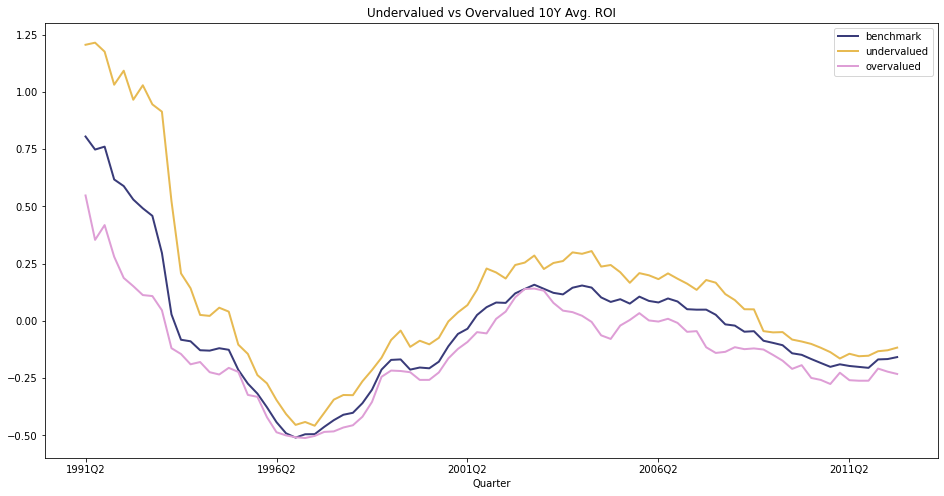

In [12]:
# Top decile undervalued and overvalued no limits
ts_roi.plot(figsize=(16,8), title='Undervalued vs Overvalued 10Y Avg. ROI', colormap='tab20b', linewidth=2, xlabel='Quarter')
plt.show()